# AutoEncoder를 이용하여 이미지 검색 엔진 만들기

입력 : 이미지 A
출력 : 이미지 A와 비슷한 이미지 5개 후보 출력

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
import numpy as np
import pandas as pd
# import plotly.express as px
from tqdm.auto import tqdm

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", device)

Using Device: cuda


In [2]:
epochs = 10
batch_size = 256
learning_rate = 0.001

In [3]:
dataset = datasets.FashionMNIST(root = './data/', train = True, download = True, transform = transforms.ToTensor())
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
data_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, num_workers = 1)

testset = datasets.FashionMNIST(root = './data/', train = False, download = True, transform = transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset = testset, batch_size = 5, shuffle = True, num_workers = 1)

In [4]:
labels_num = dataset.targets.numpy()
labels = [class_names[i] for i in labels_num]

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Linear(28 * 28, 256), 
            nn.ReLU(),
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(), 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded) 
        return encoded, decoded

In [6]:
model = Autoencoder().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.MSELoss() 

In [7]:
# 잡음 더하기
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2 
    # 무작위 작음은 torch.randn() 함수로 만들고 img.size()를 넣어 이미지와 같은 크기의 잡음을 만듭니다.
    # 잡음의 강도는 임의로 0.2로 정했습니다.
    noisy_img = img + noise
    return noisy_img

In [8]:
loss_list = []
for epoch in tqdm(range(1, epochs+1)):
    loss_value = 0
    for step, (x, label) in enumerate(data_loader):
        model.train()
        x = add_noise(x)  # 입력에 노이즈 더하기
        x = x.view(-1, 28*28).to(device)
        y = x.view(-1, 28*28).to(device) 
        label = label.to(device)

        encoded, decoded = model(x)

        loss = criterion(decoded, y)
        loss_value += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss_value)
    print("Epoch : ", epoch, ', Loss : ', loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch :  1 , Loss :  0.07931147515773773
Epoch :  2 , Loss :  0.0731208324432373
Epoch :  3 , Loss :  0.07137001305818558
Epoch :  4 , Loss :  0.06726010143756866
Epoch :  5 , Loss :  0.06353017687797546
Epoch :  6 , Loss :  0.06456388533115387
Epoch :  7 , Loss :  0.06381849199533463
Epoch :  8 , Loss :  0.06395423412322998
Epoch :  9 , Loss :  0.06379171460866928
Epoch :  10 , Loss :  0.06382153928279877


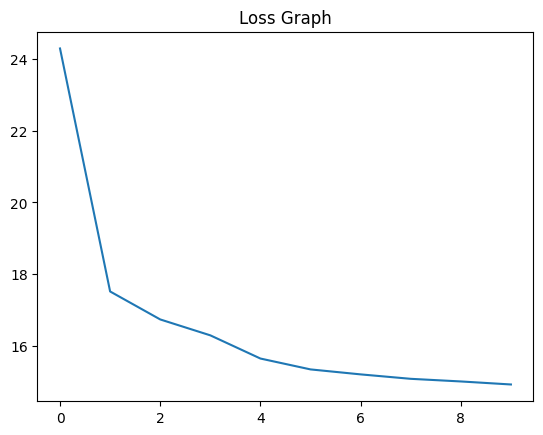

In [9]:
plt.title('Loss Graph')
plt.plot(loss_list)

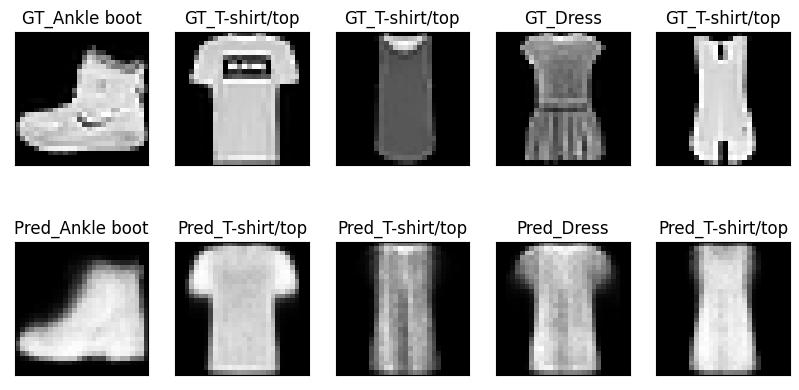

In [10]:
sample_image = dataset.data[:5].view(-1, 28*28)
sample_image = sample_image.type(torch.FloatTensor)/255.
sample_label = dataset.targets[:5]

with torch.no_grad():
    model.eval()
    test_image = sample_image.to(device)
    encode_result, decode_result = model(test_image)

f, a = plt.subplots(2, 5, figsize=(10, 5))

for i in range(5):
    img = np.reshape(sample_image.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
    a[0][i].imshow(img, cmap='gray')
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())
    a[0][i].set_title('GT_'+class_names[sample_label[i]])

for i in range(5):
    img = np.reshape(decode_result.to("cpu").data.numpy()[i], (28, 28))
    a[1][i].imshow(img, cmap='gray')
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
    a[1][i].set_title('Pred_'+class_names[sample_label[i]])
plt.show()

In [11]:
feature_list = []
labels_list = []
with torch.no_grad():
    model.eval()
    for x, y in tqdm(data_loader):
        x = x.view(-1, 28*28).to(device)
        encoded, decoded = model(x)
        for i, f in enumerate(encoded):
            feature_list.append(f.detach().cpu())
            labels_list.append(y[i].item())

  0%|          | 0/235 [00:00<?, ?it/s]

In [14]:
# 테스트 이미지 1장을 가져와서 encode 결과값을 얻자
# 그 이후 모든 feature 데이터와 유클리드 거리를 구하여 가장 가까운 TOP5 이미지 5장을 추천해준다.

In [13]:
x, y = next(iter(test_loader))

In [14]:
dist_list = []
with torch.no_grad():
    model.eval()
    x = x.to(device)
    encoded, decoded = model(x.view(-1,28*28))
    encoded = encoded.detach().cpu()

In [15]:
def get_l2_distance(x1, x2):
    return ((x1 - x2)**2).sum()**.5

In [16]:
dist = []
for e in tqdm(encoded):
    d= []
    for f in feature_list:
        d.append(get_l2_distance(e, f).item())
    dist.append(d)

  0%|          | 0/5 [00:00<?, ?it/s]

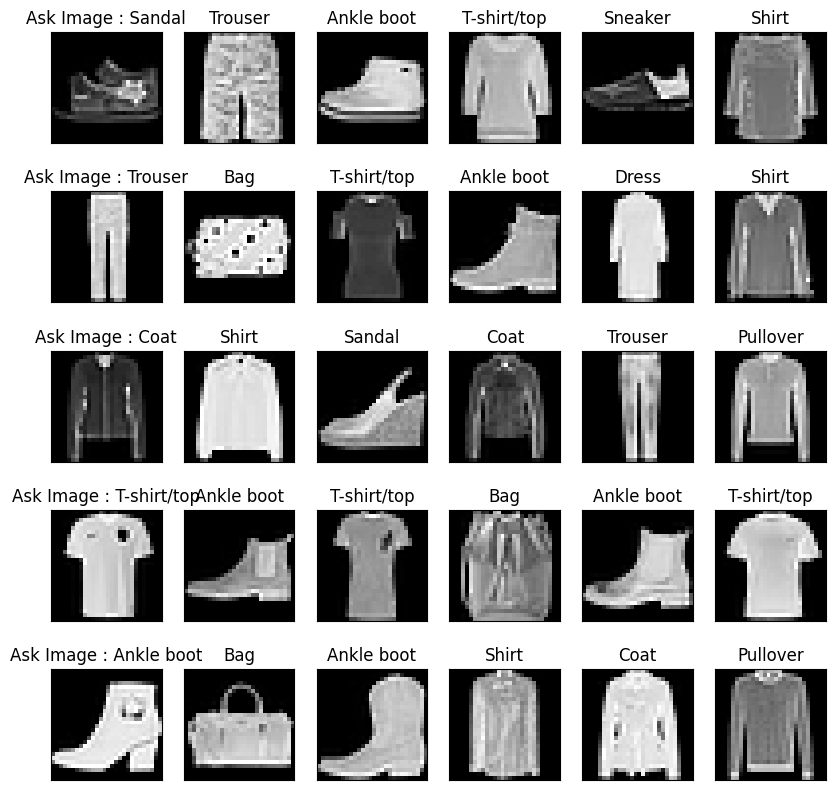

In [18]:
import copy
d = copy.deepcopy(dist)
f, a = plt.subplots(5, 6, figsize=(10, 10))

for k in range(5):
    a[k][0].imshow(x[k][0].detach().cpu().view(28,28), cmap = 'gray')
    a[k][0].set_xticks(())
    a[k][0].set_yticks(())
    a[k][0].set_title('Ask Image : '+class_names[y[k]])
    
    for i in range(1,6):
        idx = d[k].index(min(d[k]))
        a[k][i].imshow(dataset.data[idx], cmap = 'gray')
        a[k][i].set_xticks(())
        a[k][i].set_yticks(())
        a[k][i].set_title(class_names[dataset.targets[idx]])
        d[k].pop(idx)
plt.show()